In [1]:
from sklearn.cluster import KMeans
import pandas as pd
from scipy import stats

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

df1 = readTracks('../data/analysisFiles/TrackRegions1_linear2.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear2.csv')
dfD1T = pd.concat([df1,df4])
dfD1T['SigBS_mean'] = 10**(dfD1T.TS_mean/10)
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear2.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear2.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear2.csv')

In [32]:
import numpy as np
def setTrack(df,mooring):
    a = df[['TS_mean','linearSpeed','linearHead','Target_depth_mean']]
    cts,binL = np.histogram(a.linearHead,bins=36,range=[0,360])
    binL = binL[:-1]
    a['rotateHead'] = a.linearHead-(binL[cts == cts.max()].mean()+10)
    a['mooring'] = mooring
    return a

a = setTrack(dfD1T,1)
b = setTrack(dfD2T,2)
c = setTrack(dfD3T,3)
test1 = pd.concat([a,b,c])

def kmeansdf(n_k, df):
    km = KMeans(n_clusters=n_k)
    X = stats.zscore(test1[['TS_mean','linearSpeed','Target_depth_mean']])
    y_pred = km.fit_predict(X)
    test1['cluster'] = y_pred
    return test1


def clusterRat(df,mooring):
    df = df[df.mooring==mooring].sort_index()
    a=[]
    for k in df.cluster.unique():
        a.append(pd.DataFrame(df[df.cluster==k].resample('1D').count().cluster).rename(columns={'cluster':'cluster_'+str(k)}))
        
    b = df[['mooring']].resample('7D').mean()
    for a_i in a:
        b = pd.merge(b,a_i,left_index=True, right_index=True, how='outer')
    b = b.drop(columns={'mooring'})
    b = b.fillna(0)
    b['n'] = b.sum(axis=1)
    for k in df.cluster.unique():
        b['cluster_'+str(k)] = b['cluster_'+str(k)]/b.n
    return b

<ipython-input-32-d3a834062a29>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['rotateHead'] = a.linearHead-(binL[cts == cts.max()].mean()+10)
<ipython-input-32-d3a834062a29>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['mooring'] = mooring


In [33]:
df = kmeansdf(5,test1)
df1 = clusterRat(df,1)
df2 = clusterRat(df,2)
df3 = clusterRat(df,3)

In [34]:
def plotmooringClusters(df,n_k,resample=False):
    if resample:
        df = df.resample(resample).mean()
    fig = plt.figure(figsize=(17,4))
    ax1 = plt.subplot(111)
    hold = 0
    for k in [0,1,2,3,4]:
        ax1.plot(df['cluster_'+str(k)]+hold)
        ax1.fill_between(df.index,df['cluster_'+str(k)]+hold,0+hold)
        hold = df['cluster_'+str(k)]+hold
    ax1.set_xlim([pd.to_datetime('2017-8-01'),pd.to_datetime('2019-9-10')])

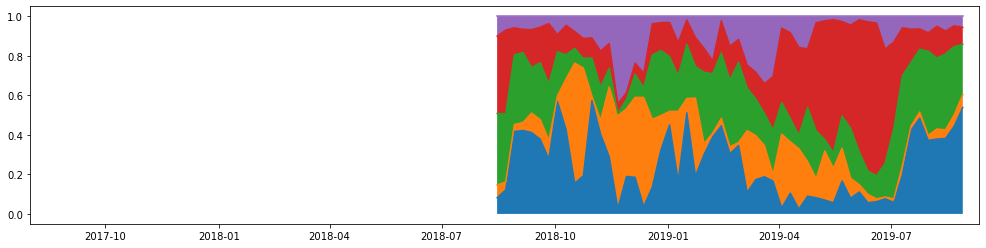

In [13]:
plotmooringClusters(df3,5,resample='7D')

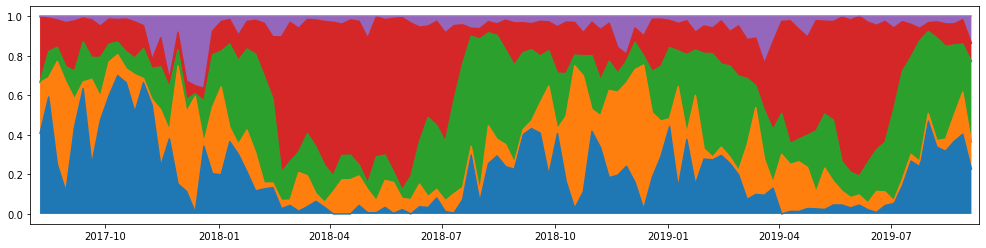

In [14]:
plotmooringClusters(df2,5,resample='7D')

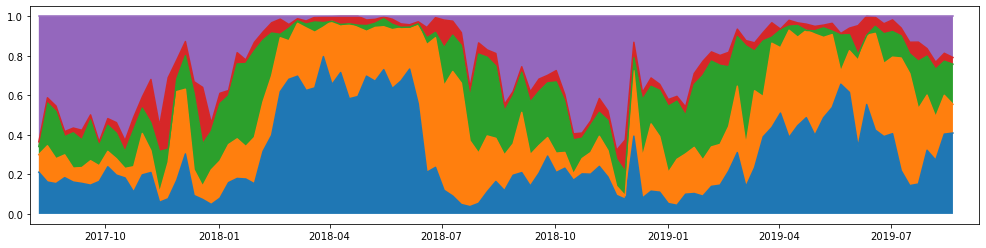

In [35]:
plotmooringClusters(df1,5,resample='7D')

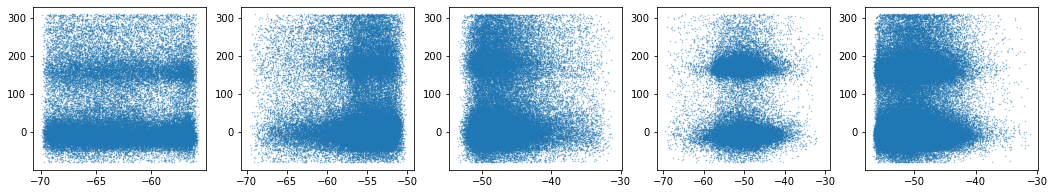

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,3))
ct = 1
for k in [0,1,2,3,4]:
    plt.subplot(1,len(df.cluster.unique()),ct)
    plt.scatter(df[df.cluster==k].TS_mean,df[df.cluster==k].rotateHead,s=.2,alpha=0.5)
    #plt.axis([-70,-30,-90,360])
    ct+=1

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,3))
ct = 1
for k in [0,1,2,3]:#4]:
    plt.subplot(1,len(df.cluster.unique()),ct)
    plt.scatter(df[df.cluster==k].TS_mean,df[df.cluster==k].rotateHead,s=.2,alpha=0.5)
    plt.axis([-70,-30,-90,360])
    ct+=1

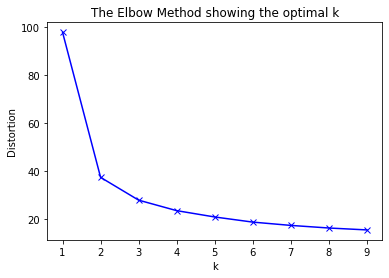

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

X = test1
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()